In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy
import seaborn as sns
from statsmodels.stats.anova import AnovaRM

import h5py

from tqdm import tqdm

In [2]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [3]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import stat as sstat

In [4]:
import warnings

---

In [5]:
dir_behav = su.get_dir_behav()

---

In [6]:
list_sn = su.get_list_sn()
list_sn

array(['01', '02', '03', '05', '06', '08', '09', '10', '11', '12', '13',
       '14'], dtype='<U2')

---

## sessions
- ses-1 (S)
- ses-2 (R)

Each session is consist of 8 runs with 68 trials (4 blocks, 17 trials for each block), additional run with long-ISI.
1. The starting trial states are randomly permuted.
2. 5s for each trial (preparation: 1s, movement: 3s, ISI: 1s)
3. Long resting period between blocks (~16 seconds)
4. Each run takes about 7 minutes
5. 17-, 34-, 57-, 64-th trial's ITI are $16000$

## motor sequences
- 32451
- 35124
- 13254
- 14523
## visual cues
- letter
- spatial

---

In [7]:
subj = 'S01'
fname = join(dir_behav,'sub-%s/behav_info.tsv'%subj)
df = pd.read_csv(fname, delimiter='\t')
df
# df.filter(items=['BN','TN','seqType','cueP',*['response%d'%d for d in range(5)],'MT','RT','complete','points','isError','iti'])

,BN,TN,onset,prepTime,cue,sequence,MT,RT,isError,ITI,response
0,1,1,8030,1000,S,2,1680,566,0,1000,35124
1,1,2,13030,1000,S,4,1720,382,0,1000,14523
2,1,3,18030,1000,L,4,2056,438,0,1000,14523
3,1,4,23030,1000,L,2,1528,478,0,1000,35124
4,1,5,28030,1000,S,1,1308,408,0,1000,32451
...,...,...,...,...,...,...,...,...,...,...,...
539,8,64,368030,1000,S,3,1360,306,0,1000,13254
540,8,65,373030,1000,L,3,1870,364,0,1000,13254
541,8,66,378030,1000,S,2,1486,412,0,1000,35124
542,8,67,383030,1000,L,2,1668,234,0,1000,35124


### (point, isError)
1) (0,0): MT=0 but the response is correct up to that point.
2) (0,1): At some point, the response becomes incorrect.
3) (1,0): A properly conducted trial.

PrepTime(1s) + press(3s) + ITI(1s) = 5s
- $\text{MT} \neq pressTime4 - pressTime0$
- $\text{RT} = pressTime0 - 1000(PrepTime) - (4\text{ or }6)$

## 1. Repetition

 | | symbol | trial$_{t-1}$ | trial $_{t}$ |
 |---------|---------|---------|---------|
 | Both-Rep$_{c}$ <br> (within-$c$ repetition) | <span style="color:#00008B">$B_{c}$</span> | $(s,c)$ | $(s,c)$ |
 | Cue-Rep$_{c}$ <br> (within-$c$ no-repetition) | <span style="color:#0000FF">$C_{c}$</span> | $(\neg s,c)$ | $(s,c)$ |
 | Seq-Rep$_{c}$ <br> (between-$c$ repetition) | <span style="color:#8B0000">$S_{c}$</span> | $(s,\neg c)$ | $(s,c)$ |
 | Non-Rep$_{c}$ <br> (between-$c$ no-repetition) | <span style="color:#FF0000">$N_{c}$</span> | $(\neg s,\neg c)$ | $(s,c)$ |

$Trial State=(s,c)$:\
$ s=0: 32451 $, $ s=1: 35124 $, $s=2: 13254 $, $s=3: 14523$ \
$ c=0: Letter $, $ c=1: Spatial $

In [8]:
df

,BN,TN,onset,prepTime,cue,sequence,MT,RT,isError,ITI,response
0,1,1,8030,1000,S,2,1680,566,0,1000,35124
1,1,2,13030,1000,S,4,1720,382,0,1000,14523
2,1,3,18030,1000,L,4,2056,438,0,1000,14523
3,1,4,23030,1000,L,2,1528,478,0,1000,35124
4,1,5,28030,1000,S,1,1308,408,0,1000,32451
...,...,...,...,...,...,...,...,...,...,...,...
539,8,64,368030,1000,S,3,1360,306,0,1000,13254
540,8,65,373030,1000,L,3,1870,364,0,1000,13254
541,8,66,378030,1000,S,2,1486,412,0,1000,35124
542,8,67,383030,1000,L,2,1668,234,0,1000,35124


In [9]:
dg = pd.DataFrame()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for sess in ['S','R']:
        for sn in tqdm(list_sn):
            subj = sess+sn
            fname = join(dir_behav,'sub-%s/behav_info.tsv'%subj)
            df = pd.read_csv(fname, delimiter='\t')
            df_tmp = df.copy()
    
            df_tmp['ITI-1'] = df.ITI.shift(1)
            df_tmp['cue-1'] = df.cue.shift(1)
            df_tmp['sequence-1'] = df.sequence.shift(1)
            df_tmp['RT-1'] = df.RT.shift(1)
            df_tmp['MT-1'] = df.MT.shift(1)
            
            ## 1 <= TN <= 64
            df = df_tmp[(df_tmp.TN>1)&(df_tmp.TN<=64)].copy()
            ## ITI-1 <= 1000 ms
            df = df[df['ITI-1']<=1000]
            # df = df[df['isError']==0]
    
            df['ITI-1'] = df['ITI-1'].astype(int)
            # df['cue-1'] = df['cue-1'].astype(int)
            df['sequence-1'] = df['sequence-1'].astype(int)
            df['RT-1'] = df['RT-1'].astype(int)
            df['MT-1'] = df['MT-1'].astype(int)
            
            ## default condition = NRep
            df['cond'] = 'Non-Rep'
            ## other conditions
            df.loc[(df.cue==df['cue-1'])&(df.sequence==df['sequence-1']),'cond'] = 'Both-Rep'
            df.loc[(df.cue==df['cue-1'])&(df.sequence!=df['sequence-1']),'cond'] = 'Cue-Rep'
            df.loc[(df.cue!=df['cue-1'])&(df.sequence==df['sequence-1']),'cond'] = 'Seq-Rep'
            ## subj label
            df['sess']=sess
            df['subj']=sn
            df['x'] = ['%s_%s'%(cue,sess) for cue,sess in zip(df['cue'], df['sess'])]
            ## 수행한 total trial number
            df_tmp['trial']=(df.BN-1)*64+df.TN
            
            dg = pd.concat([dg,df])
dg

100%|███████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.28it/s]


,BN,TN,onset,prepTime,cue,sequence,MT,RT,isError,ITI,response,ITI-1,cue-1,sequence-1,RT-1,MT-1,cond,sess,subj,x
1,1,2,13030,1000,S,4,1720,382,0,1000,14523,1000,S,2,566,1680,Cue-Rep,S,01,S_S
2,1,3,18030,1000,L,4,2056,438,0,1000,14523,1000,S,4,382,1720,Seq-Rep,S,01,L_S
3,1,4,23030,1000,L,2,1528,478,0,1000,35124,1000,L,4,438,2056,Cue-Rep,S,01,L_S
4,1,5,28030,1000,S,1,1308,408,0,1000,32451,1000,L,2,478,1528,Non-Rep,S,01,S_S
5,1,6,33030,1000,L,2,1776,446,0,1000,35124,1000,S,1,408,1308,Non-Rep,S,01,L_S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,8,60,348020,1000,L,3,1060,322,0,1000,13254,1000,S,3,374,1038,Seq-Rep,R,14,L_R
536,8,61,353020,1000,S,2,1042,308,0,1000,35124,1000,L,3,322,1060,Non-Rep,R,14,S_R
537,8,62,358020,1000,L,2,1172,312,0,1000,35124,1000,S,2,308,1042,Seq-Rep,R,14,L_R
538,8,63,363020,1000,L,4,1010,348,0,1000,14523,1000,L,2,312,1172,Cue-Rep,R,14,L_R


In [10]:
## invalid trial들은 제거 후 평균
dg_groupby = dg.groupby(['sess','subj','cue','cond','x'])[['isError','MT','RT','MT-1','RT-1']].mean().reset_index()
dg_groupby['cond'] = dg_groupby.cond.replace({
    'Both-Rep':'Within Rep', 'Cue-Rep':'Within No-Rep',
    'Seq-Rep':'Between Rep', 'Non-Rep':'Between No-Rep'
})
dg_groupby

,sess,subj,cue,cond,x,isError,MT,RT,MT-1,RT-1
0,R,01,L,Within Rep,L_R,0.000000,1485.250000,368.687500,1494.312500,367.062500
1,R,01,L,Within No-Rep,L_R,0.055556,1514.933333,375.177778,1485.644444,372.977778
2,R,01,L,Between No-Rep,L_R,0.034483,1475.287356,361.402299,1412.183908,339.448276
3,R,01,L,Between Rep,L_R,0.064516,1536.516129,373.741935,1462.967742,356.387097
4,R,01,S,Within Rep,S_R,0.000000,1368.250000,322.250000,1399.000000,340.250000
...,...,...,...,...,...,...,...,...,...,...
187,S,14,L,Between Rep,L_S,0.068966,1026.896552,359.172414,977.586207,354.827586
188,S,14,S,Within Rep,S_S,0.032258,952.709677,327.870968,954.838710,318.193548
189,S,14,S,Within No-Rep,S_S,0.011111,960.266667,336.200000,981.488889,339.000000
190,S,14,S,Between No-Rep,S_S,0.033708,970.786517,333.483146,997.393258,391.370787


In [11]:
hue_order = ['Within Rep','Within No-Rep','','Between Rep','Between No-Rep']
palette = ['#191970','#89CFF0','#FFFFFF','#800020','#F08080']

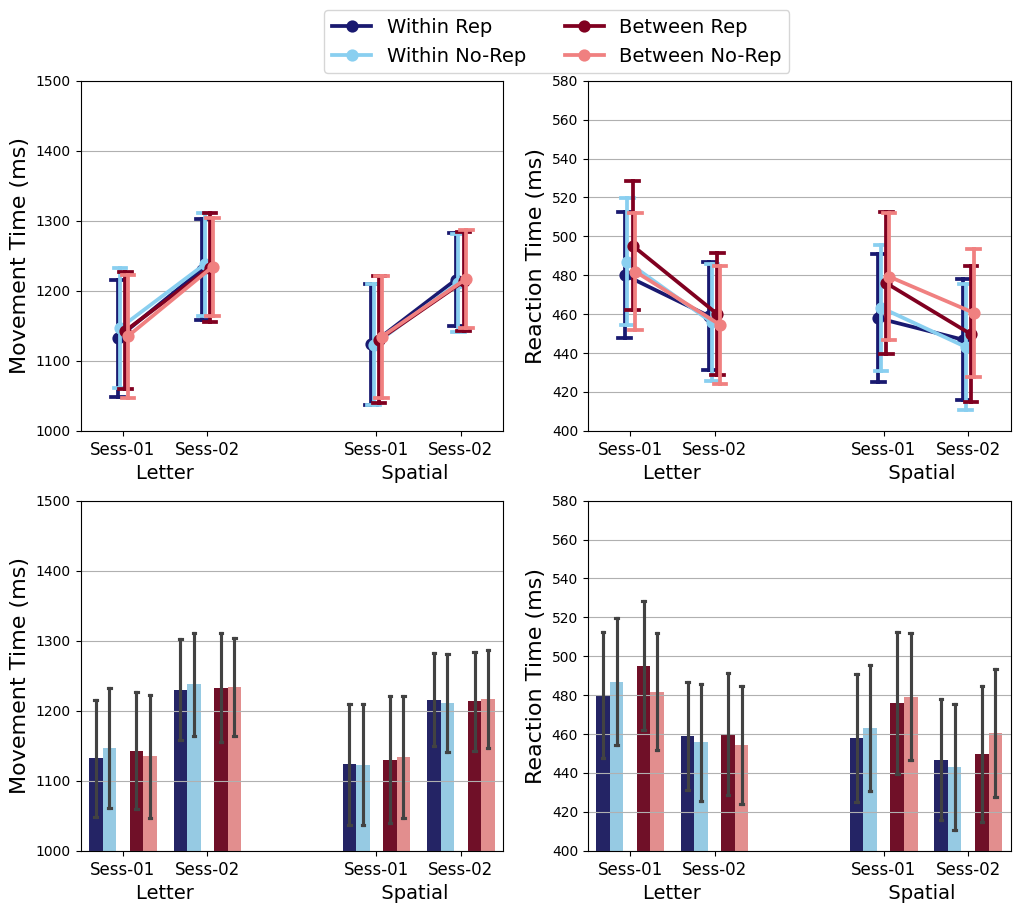

In [12]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,10))

for aa in range(2):
    for ii, feature in enumerate(['MT','RT']):
        ax = axs[aa,ii]
        if aa == 0:
            g = sns.pointplot(
                data=dg_groupby,
                x='x', order=['L_S','L_R','','S_S','S_R'],
                y=feature, estimator='mean',
                hue='cond', hue_order=hue_order,
                capsize=0.15, errorbar='se', dodge=True,
                palette=palette,
                ax=ax
            )
        else:
            g = sns.barplot(
                data=dg_groupby,
                x='x', order=['L_S','L_R','','S_S','S_R'],
                y=feature, estimator='mean',
                hue='cond', hue_order=hue_order,
                capsize=0.15, errorbar='se',
                palette=palette,
                ax=ax
            )
        g.legend()
        g.grid(axis='y')
        g.legend().remove()
        if ii == 0:
            g.set_ylabel('Movement Time (ms)',fontsize=16)
            g.set_ylim(1000,1500)
        elif ii == 1:
            g.set_ylabel('Reaction Time (ms)',fontsize=16)
            g.set_ylim(400,580)
            if aa == 0:
                g.legend(loc='best', bbox_to_anchor=(0.50, 1.23), ncol=2, fontsize=14)
        g.set_xlabel('Letter%sSpatial'%''.ljust(30), fontsize=14)
        g.set_xticks([0,1,3,4])
        g.set_xticklabels(['Sess-01','Sess-02','Sess-01','Sess-02'], fontsize=12)
        # g.set_xticklabels(['Letter$_{S}$','Spatial$_{S}$','Letter$_{R}$','Spatial$_{R}$'],fontsize=14)
        # g.set_title('session %s'%sess,fontsize=16)
        
# fig.tight_layout()

---

## ANOVA

In [13]:
for value in ['MT','RT']:
    print(value)
    aov = AnovaRM(
        data=dg_groupby,
        depvar=value,
        subject='subj',
        within=['sess','cue','cond']
    ).fit()
    print(aov)

MT
                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
sess           2.5779 1.0000 11.0000 0.1367
cue           27.9835 1.0000 11.0000 0.0003
cond           0.2559 3.0000 33.0000 0.8566
sess:cue       0.2928 1.0000 11.0000 0.5992
sess:cond      0.1866 3.0000 33.0000 0.9047
cue:cond       1.0077 3.0000 33.0000 0.4017
sess:cue:cond  0.1259 3.0000 33.0000 0.9441

RT
                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
sess           1.7026 1.0000 11.0000 0.2186
cue            4.9498 1.0000 11.0000 0.0480
cond           3.0476 3.0000 33.0000 0.0423
sess:cue       6.4937 1.0000 11.0000 0.0271
sess:cond      1.9027 3.0000 33.0000 0.1484
cue:cond       3.5456 3.0000 33.0000 0.0249
sess:cue:cond  0.0095 3.0000 33.0000 0.9987



## paired t-test

#### i) Comparing different cues

In [14]:
tmp = dg.groupby(['subj','cue'])[['MT','RT']].mean().reset_index()
tmp

,subj,cue,MT,RT
0,01,L,1637.962733,398.211180
1,01,S,1607.987421,364.368973
2,02,L,1147.420290,380.024845
3,02,S,1118.649895,359.798742
4,03,L,1135.630252,416.348739
5,03,S,1131.074380,441.644628
6,05,L,1210.806653,426.602911
7,05,S,1211.407098,426.676409
8,06,L,1186.878661,709.933054
9,06,S,1176.190871,703.381743


MT: t(11)=5.6215 (****)
RT: t(11)=1.7765 (ns)
MT: t(11)=5.6215 (****)
RT: t(11)=1.7765 (ns)


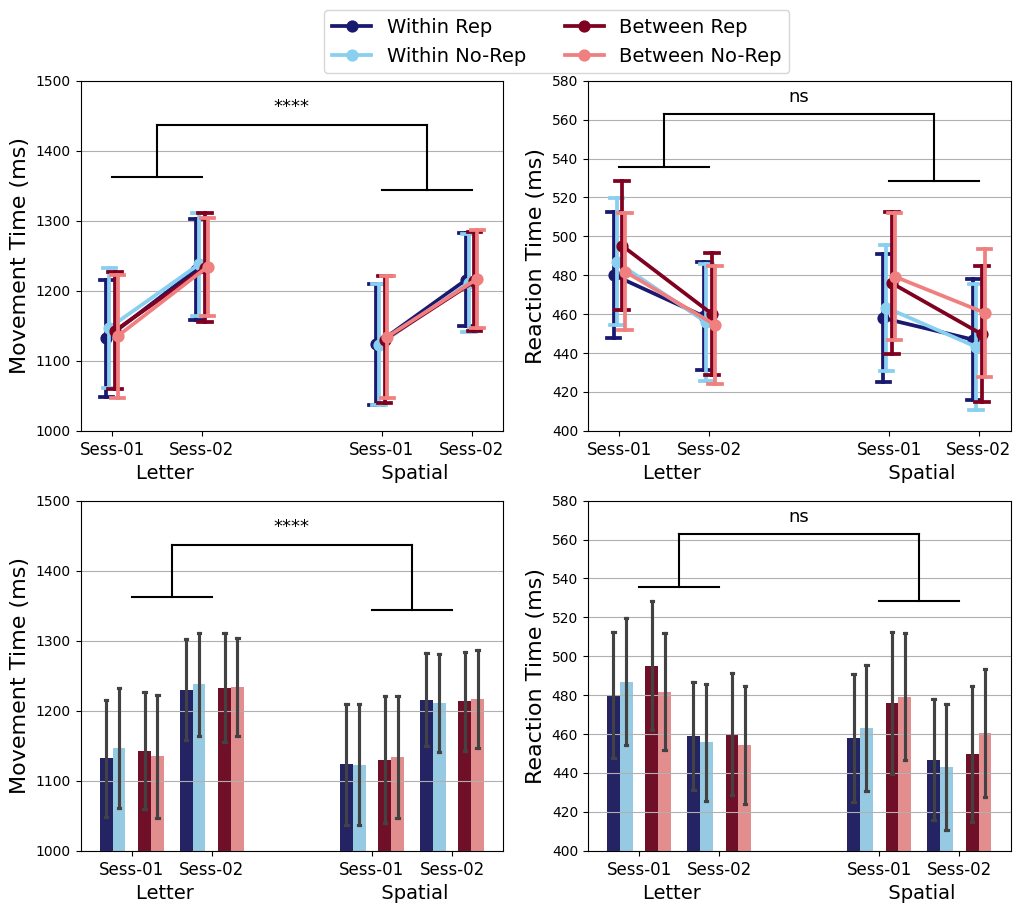

In [15]:
color = 'black'
for aa in range(2):
    for ii, value in enumerate(['MT','RT']):
        ax = axs[aa,ii]
        ## t-test
        a = tmp[tmp.cue=='L'][value].astype(float)
        b = tmp[tmp.cue=='S'][value].astype(float)
        res = scipy.stats.ttest_rel(a,b,alternative='greater')
        tval = res.statistic
        pval = res.pvalue
        print('%s: t(%d)=%.4f (%s)'%(value, res.df, res.statistic, sstat.convert_pval_to_star(res.pvalue)))
        
        ylim = np.array(ax.get_ylim())
        ydiff = np.diff(ylim)[0]
        ymean = ylim.mean()
        dy = ydiff * 0.05
        # ax.set_ylim([ymean-ydiff*0.8, ymean+ydiff*0.9])
        
        x1 = 0.5
        y1 = a.mean() + a.sem() + dy*4
        ax.plot([0,1],[y1,y1],linestyle='-',color=color)
        x2 = 3.5
        y2 = b.mean() + b.sem() + dy*4
        ax.plot([3,4],[y2,y2],linestyle='-',color=color)
        yU = max(y1,y2) + dy*3
        ax.plot([x1,x1],[y1,yU],linestyle='-',color=color)
        ax.plot([x2,x2],[y2,yU],linestyle='-',color=color)
        ax.plot([x1,x2],[yU,yU],linestyle='-',color=color)
        ax.text(
            (x1+x2)*0.5, yU+dy,
            sstat.convert_pval_to_star(pval), fontsize=13, color=color,
            ha='center', va='center'
        )
fig

#### ii) Differences across session

In [16]:
tmp = dg.groupby(['subj','sess'])[['isError','MT','RT']].mean().reset_index()
tmp

,subj,sess,isError,MT,RT
0,01,R,0.047917,1463.066667,350.837500
1,01,S,0.060417,1783.070833,411.954167
2,02,R,0.010417,1235.854167,365.937500
3,02,S,0.008333,1030.395833,374.012500
4,03,R,0.018750,1223.720833,416.445833
5,03,S,0.022917,1042.945833,441.758333
6,05,R,0.004167,1327.291667,428.112500
7,05,S,0.020833,1094.920833,425.166667
8,06,R,0.002083,1312.808333,678.241667
9,06,S,0.027083,1050.216667,735.045833


t(11)=2.5109 (*)


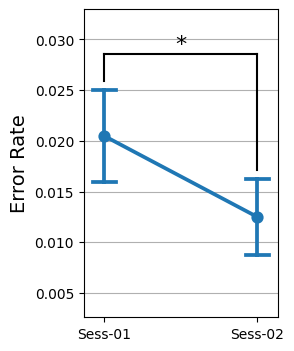

In [17]:
_, ax = plt.subplots(figsize=(2.5,4))
g = sns.pointplot(
    data = tmp,
    x = 'sess', order=['S','R'],
    y='isError',
    errorbar='se', capsize=0.15
)
g.grid(axis='y')
g.set_xlabel('')
g.set_ylabel('Error Rate', fontsize=14)
g.set_xticks([0,1])
g.set_xticklabels(['Sess-01','Sess-02'])

## t-test
a = tmp[tmp.sess=='S']['isError'].astype(float)
b = tmp[tmp.sess=='R']['isError'].astype(float)
res = scipy.stats.ttest_rel(a,b,alternative='greater')
tval = res.statistic
pval = res.pvalue
print('t(%d)=%.4f (%s)'%(res.df, tval, sstat.convert_pval_to_star(pval)))

ylim = np.array(g.get_ylim())
ydiff = np.diff(ylim)[0]
ymean = ylim.mean()
dy = ydiff * 0.05
g.set_ylim([ymean-ydiff*0.8, ymean+ydiff*0.9])
if pval < 0.05:
    x1 = 0
    x2 = 1
    y1 = a.mean() + a.sem() + dy
    y2 = b.mean() + b.sem() + dy
    yU = max(y1,y2) + dy*3
    color = 'black'
    g.plot([x1,x1],[y1,yU],linestyle='-',color=color)
    g.plot([x2,x2],[y2,yU],linestyle='-',color=color)
    g.plot([x1,x2],[yU,yU],linestyle='-',color=color)
    g.text(
        (x1+x2)*0.5, yU+dy,
        sstat.convert_pval_to_star(pval), fontsize=16, color=color,
        ha='center', va='center'
    )

#### iii) Repetition advaantage in MT and RT

In [18]:
tmp = dg.groupby(['subj','sess','cond','cue'])[['MT','RT']].mean().reset_index()
tmp

,subj,sess,cond,cue,MT,RT
0,01,R,Both-Rep,L,1485.250000,368.687500
1,01,R,Both-Rep,S,1368.250000,322.250000
2,01,R,Cue-Rep,L,1514.933333,375.177778
3,01,R,Cue-Rep,S,1428.777778,318.622222
4,01,R,Non-Rep,L,1475.287356,361.402299
...,...,...,...,...,...,...
187,14,S,Cue-Rep,S,960.266667,336.200000
188,14,S,Non-Rep,L,1004.494382,368.516854
189,14,S,Non-Rep,S,970.786517,333.483146
190,14,S,Seq-Rep,L,1026.896552,359.172414


In [19]:
for ii, sess in enumerate(['S','R']):
    print('sess %s'%sess)
    for jj, cue in enumerate(['L','S']):
        print('cue %s'%cue)
        for kk, value in enumerate(['MT','RT']):
            ## t-test
            a = tmp[(tmp.sess==sess)&(tmp.cue==cue)&(tmp.cond=='Both-Rep')][value].astype(float)
            b = tmp[(tmp.sess==sess)&(tmp.cue==cue)&(tmp.cond=='Cue-Rep')][value].astype(float)
            res = scipy.stats.ttest_rel(a,b,alternative='less')
            tval = res.statistic
            pval = res.pvalue
            print('%s (%s): t(%d)=%.4f (%s)'%('B vs. C', value, res.df, tval, sstat.convert_pval_to_star(pval)))
    
            a = tmp[(tmp.sess==sess)&(tmp.cue==cue)&(tmp.cond=='Seq-Rep')][value].astype(float)
            b = tmp[(tmp.sess==sess)&(tmp.cue==cue)&(tmp.cond=='Non-Rep')][value].astype(float)
            res = scipy.stats.ttest_rel(a,b,alternative='less')
            tval = res.statistic
            pval = res.pvalue
            print('%s (%s): t(%d)=%.4f (%s)'%('S vs. N', value, res.df, tval, sstat.convert_pval_to_star(pval)))
        print('')

sess S
cue L
B vs. C (MT): t(11)=-1.0892 (ns)
S vs. N (MT): t(11)=0.6029 (ns)
B vs. C (RT): t(11)=-1.3199 (ns)
S vs. N (RT): t(11)=1.2985 (ns)

cue S
B vs. C (MT): t(11)=0.0386 (ns)
S vs. N (MT): t(11)=-0.3326 (ns)
B vs. C (RT): t(11)=-0.9974 (ns)
S vs. N (RT): t(11)=-0.3823 (ns)

sess R
cue L
B vs. C (MT): t(11)=-0.6989 (ns)
S vs. N (MT): t(11)=-0.1232 (ns)
B vs. C (RT): t(11)=0.3867 (ns)
S vs. N (RT): t(11)=0.9860 (ns)

cue S
B vs. C (MT): t(11)=0.3419 (ns)
S vs. N (MT): t(11)=-0.3960 (ns)
B vs. C (RT): t(11)=0.8933 (ns)
S vs. N (RT): t(11)=-2.1201 (*)



---

-> Spatial 에서 더 빨라야 할거 같은데? yes

In [30]:
fig.savefig(
    join(dir_work,'results/fig.behav.Rep.barplot.png'),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches='tight'
)

### 왜 session R에서 MT가 더 높은가?
- 단순히 더 정확히 하기 위해서 느려진 것이 아닌가?

In [18]:
palette = ['#4a83d1','#d1984a']

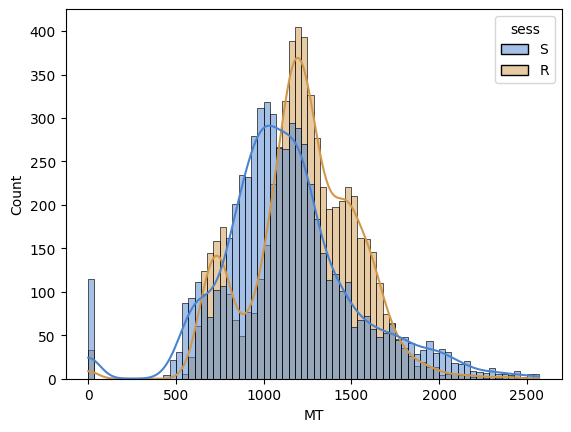

In [19]:
g = sns.histplot(
    data=dg,
    x='MT',
    hue='sess', palette=palette, kde=True,
    alpha=0.5
)
# g.legend()

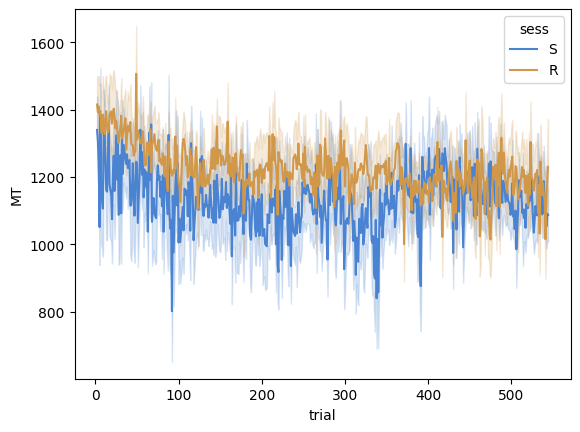

In [20]:
g = sns.lineplot(
    data=dg,
    x='trial', y='MT',
    hue='sess', palette=palette,
    errorbar='se', err_style='band'
)

-> 실험 초반에 느리게 함. 정확성을 위해서가 맞는 듯.

---

## 2. Sequence: 어떤 Seq가 어려웠나?

In [21]:
df = pd.DataFrame()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    for subj in list_subj:
        fname = join(dir_behav,'ssh__%s.dat'%subj)
        df_tmp = pd.read_csv(fname, delimiter='\t')
        df_tmp = df_tmp[['BN','TN','seqType','cueP','MT','RT','points','isError']]
        
        ## 각 run의 가장 마지막 trial은 제외
        # df = df[df.iti<2000]

        ## 9번째 run (long ITI)은 제거
        df_tmp = df_tmp[df_tmp.BN < 9]

        ## 성공적으로 수행한 trial들만 고려
        df_tmp = df_tmp[df_tmp.points == 1]

        df_tmp.seqType = ['Letter' if i==0 else 'Spatial' for i in df_tmp.seqType]
        df_tmp.cueP = df_tmp.cueP.astype('str')

        df_tmp['sess'] = subj[0]
        df_tmp['subj'] = subj[1:]
        # df_tmp['hue'] = ['%s_%s'%(seq,ses) for seq,ses in zip(df_tmp.seqType,df_tmp.sess)]

        df = pd.concat([df,df_tmp])
df

,BN,TN,seqType,cueP,MT,RT,points,isError,sess,subj
0,1,1,Spatial,35124,1680,566,1,0,S,01
1,1,2,Spatial,14523,1720,382,1,0,S,01
2,1,3,Letter,14523,2056,438,1,0,S,01
3,1,4,Letter,35124,1528,478,1,0,S,01
4,1,5,Spatial,32451,1308,408,1,0,S,01
...,...,...,...,...,...,...,...,...,...,...
539,8,64,Letter,13254,1022,346,1,0,R,14
540,8,65,Letter,32451,1054,366,1,0,R,14
541,8,66,Letter,14523,1014,526,1,0,R,14
542,8,67,Letter,32451,1028,328,1,0,R,14


In [22]:
df_groupby = df.groupby(['sess','subj','seqType','cueP'])[['MT','RT']].mean().reset_index()
print('n_sess * n_subj * n_cue * n_seq = %d'%(2*12*2*4))
df_groupby

n_sess * n_subj * n_cue * n_seq = 192


,sess,subj,seqType,cueP,MT,RT
0,R,01,Letter,13254,1532.969697,376.181818
1,R,01,Letter,14523,1695.114754,380.622951
2,R,01,Letter,32451,1355.250000,363.218750
3,R,01,Letter,35124,1443.939394,390.242424
4,R,01,Spatial,13254,1405.365079,337.936508
...,...,...,...,...,...,...
187,S,14,Letter,35124,938.656716,368.358209
188,S,14,Spatial,13254,937.384615,349.384615
189,S,14,Spatial,14523,958.477612,337.910448
190,S,14,Spatial,32451,974.176471,320.911765


MT
32451
t(23)=3.9670, ***p=0.0006
35124
t(23)=0.1105, nsp=0.9129
13254
t(23)=3.4324, **p=0.0023
14523
t(23)=3.1798, **p=0.0042
RT
32451
t(23)=6.2709, ****p=0.0000
35124
t(23)=2.2118, *p=0.0372
13254
t(23)=0.5552, nsp=0.5841
14523
t(23)=-0.1176, nsp=0.9074


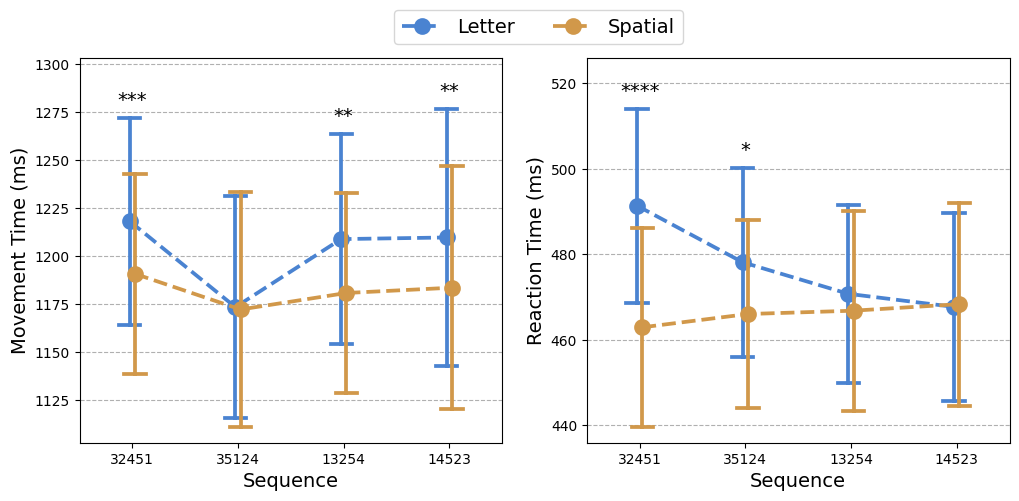

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))

hue = 'seqType'
# hue = 'sess'
for ii, feature in enumerate(['MT','RT']):
    print(feature)
    ax = axs[ii]
    g = sns.pointplot(
        data=df_groupby,
        x='cueP', order=list_seq, y=feature, hue=hue,
        linestyles='--', markers=['o','o'], markersize=10, palette=palette,
        errorbar='se', capsize=0.2, dodge=True,
        ax=ax
    )
    # g = sns.barplot(
    #     data=df_groupby,
    #     x='cueP', y=feature,
    #     hue='seqType', order=list_seq, palette=palette,
    #     errorbar='se', capsize=0.2, dodge=False,
    #     ax=ax
    # )
    g.grid(axis='y', linestyle='--')
    if ii==0:
        g.legend(loc='best', bbox_to_anchor=(1.45, 1.15), ncol=2, fontsize=14)
    else:
        g.legend().remove()
    g.set_xlabel('Sequence', fontsize=14)
    ylabel = 'Movement Time (ms)' if feature=='MT' else 'Reaction Time (ms)'
    g.set_ylabel(ylabel, fontsize=14)
    ya, yb = g.get_ylim()
    dy = (yb-ya) * 0.05

    ## t-test
    for ss, seq in enumerate(list_seq):
        print(seq)
        a = df_groupby[(df_groupby.seqType=='Letter')&(df_groupby.cueP==seq)][feature].astype(float)
        b = df_groupby[(df_groupby.seqType=='Spatial')&(df_groupby.cueP==seq)][feature].astype(float)
        res = scipy.stats.ttest_rel(a,b)
        tval, pval = res
        dof = res.df
        print('t(%d)=%.4f, %sp=%.4f'%(dof,tval,convert_pvalue_to_asterisks(pval),pval))
        
        if pval < 0.05:
            x = ss # + 0.2*(cc-1.5)
            y1 = a.mean()+a.sem()
            y2 = b.mean()+b.sem()
            y = max(y1,y2) + dy
            
            g.text(
                x, y,
                convert_pvalue_to_asterisks(pval), fontsize=14, color='black',
                ha='center', va='center',
            )
    g.set_ylim(ya,yb+dy*2)

-> Spatial Cue의 경우 직관적이므로, 반응시간(RT)과 입력시간(MT) 모두 단축되었으며, sequence에 관계없이 비슷한 시간들을 나타낸다.

-> Letter: sequence에 '45'가 포함되어 있는 경우는 느린듯 (MT$\uparrow$), 마찬가지로 첫 손가락이 '3'인 경우도 반응이 느린듯 (RT$\uparrow$)

In [24]:
fig.savefig(
    join(dir_work,'results/fig.behav.sequence.pointplot.png'),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches='tight'
)

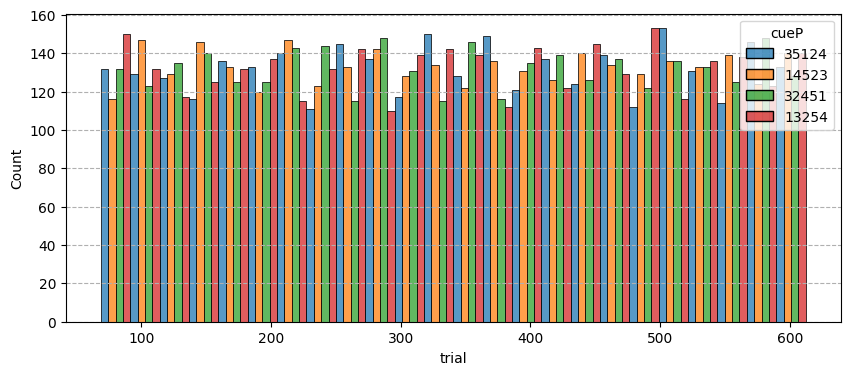

In [25]:
fig, ax = plt.subplots(figsize=(10,4))
df['trial'] = df.BN*68 + df.TN
g = sns.histplot(
    data=df,
    x='trial', stat='count', kde=False,
    hue='cueP', multiple='dodge',
    ax=ax
)
# g.legend()
g.grid(axis='y', linestyle='--')

---